<a href="https://colab.research.google.com/github/eunicean/Proyecto3-Paralela/blob/main/proyecto3_paralela.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [254]:
!git clone https://github.com/eunicean/Proyecto3-Paralela.git

fatal: destination path 'Proyecto3-Paralela' already exists and is not an empty directory.


In [255]:
!apt-get install -y libpng-dev

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libpng-dev is already the newest version (1.6.37-3build5).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.


In [256]:
!pip install nvcc4jupyter
%load_ext nvcc4jupyter

The nvcc4jupyter extension is already loaded. To reload it, use:
  %reload_ext nvcc4jupyter


In [257]:
# Detect selected GPU and its NVIDA architecture:
import subprocess
gpu_info = subprocess.getoutput("nvidia-smi --query-gpu=name,compute_cap --format=csv,noheader,nounits")
if "not found" in gpu_info.lower(): raise RuntimeError("Error: No GPU found. Please select a GPU runtime environment.")
gpu_name, compute_cap = map(str.strip, gpu_info.split(','))
gpu_arch = f"sm_{compute_cap.replace('.', '')}"

print(f"{'GPU Name':<15}: {gpu_name}")
print(f"{'Architecture':<15}: {gpu_arch}")

GPU Name       : Tesla T4
Architecture   : sm_75


In [258]:
%%writefile pgm.h
#ifndef PGM_H
#define PGM_H

#include <stdio.h>
#include <stdlib.h>
#include <string.h>

class PGMImage {
public:
    int x_dim, y_dim;
    unsigned char *pixels;

    PGMImage(const char *filename) {
        FILE *file = fopen(filename, "rb");
        if (!file) {
            printf("Error: No se pudo abrir el archivo %s\n", filename);
            x_dim = y_dim = 0;
            pixels = NULL;
            return;
        }

        char magic[3];
        fscanf(file, "%2s\n", magic);

        // Saltar comentarios
        char c = getc(file);
        while (c == '#') {
            while (getc(file) != '\n');
            c = getc(file);
        }
        ungetc(c, file);

        fscanf(file, "%d %d\n", &x_dim, &y_dim);
        int maxVal;
        fscanf(file, "%d\n", &maxVal);

        pixels = new unsigned char[x_dim * y_dim];
        fread(pixels, sizeof(unsigned char), x_dim * y_dim, file);
        fclose(file);
    }

    ~PGMImage() {
        if (pixels) delete[] pixels;
    }
};

#endif

Overwriting pgm.h


In [259]:
%%writefile houghBase.cu
/*
 ============================================================================
 Author        : G. Barlas
 Version       : 1.0
 Last modified : December 2014
 License       : Released under the GNU GPL 3.0
 Description   :
 To build use  : make
 ============================================================================
 */

#include <stdio.h>
#include <stdlib.h>
#include <math.h>
#include <cuda.h>
#include <string.h>
#include "pgm.h"
#include <png.h>

const int degreeInc = 2;
const int degreeBins = 180 / degreeInc;
const int rBins = 100;
const float radInc = degreeInc * M_PI / 180;

//*****************************************************************
// Función para guardar imagen PNG
int savePNG(const char* filename, unsigned char* data, int w, int h) {
    FILE *fp = fopen(filename, "wb");
    if (!fp) {
        printf("No se pudo abrir el archivo para escribir: %s\n", filename);
        return -1;
    }

    png_structp png_ptr = png_create_write_struct(PNG_LIBPNG_VER_STRING, NULL, NULL, NULL);
    if (!png_ptr) {
        fclose(fp);
        return -1;
    }

    png_infop info_ptr = png_create_info_struct(png_ptr);
    if (!info_ptr) {
        png_destroy_write_struct(&png_ptr, NULL);
        fclose(fp);
        return -1;
    }

    if (setjmp(png_jmpbuf(png_ptr))) {
        png_destroy_write_struct(&png_ptr, &info_ptr);
        fclose(fp);
        return -1;
    }

    png_init_io(png_ptr, fp);

    // Configurar header PNG (RGB, 8 bits por canal)
    png_set_IHDR(png_ptr, info_ptr, w, h, 8, PNG_COLOR_TYPE_RGB,
                 PNG_INTERLACE_NONE, PNG_COMPRESSION_TYPE_DEFAULT,
                 PNG_FILTER_TYPE_DEFAULT);

    png_write_info(png_ptr, info_ptr);

    // Preparar filas para libpng
    png_bytep *row_pointers = (png_bytep*)malloc(sizeof(png_bytep) * h);
    for (int y = 0; y < h; y++) {
        row_pointers[y] = (png_byte*)malloc(png_get_rowbytes(png_ptr, info_ptr));
        memcpy(row_pointers[y], data + y * w * 3, w * 3);
    }

    png_write_image(png_ptr, row_pointers);
    png_write_end(png_ptr, NULL);

    // Liberar memoria
    for (int y = 0; y < h; y++) {
        free(row_pointers[y]);
    }
    free(row_pointers);
    png_destroy_write_struct(&png_ptr, &info_ptr);
    fclose(fp);

    printf("Imagen PNG guardada: %s\n", filename);
    return 0;
}

//*****************************************************************
// Función para dibujar una línea en la imagen
void drawLine(unsigned char* colorImg, int w, int h, float r, float theta, unsigned char r_val, unsigned char g_val, unsigned char b_val) {
    int xCent = w / 2;
    int yCent = h / 2;

    float cos_theta = cos(theta);
    float sin_theta = sin(theta);

    // Calcular puntos extremos de la línea
    if (fabs(sin_theta) > 0.0001) {
        // Línea no vertical - calcular intersecciones con bordes superior e inferior
        for (int x = 0; x < w; x++) {
            int xCoord = x - xCent;
            float yCoord = (r - xCoord * cos_theta) / sin_theta;
            int y = yCent - (int)yCoord;

            if (y >= 0 && y < h) {
                int idx = (y * w + x) * 3;
                colorImg[idx] = r_val;     // Rojo
                colorImg[idx + 1] = g_val; // Verde
                colorImg[idx + 2] = b_val; // Azul
            }
        }
    }

    if (fabs(cos_theta) > 0.0001) {
        // Línea no horizontal - calcular intersecciones con bordes izquierdo y derecho
        for (int y = 0; y < h; y++) {
            int yCoord = yCent - y;
            float xCoord = (r - yCoord * sin_theta) / cos_theta;
            int x = xCoord + xCent;

            if (x >= 0 && x < w) {
                int idx = (y * w + x) * 3;
                colorImg[idx] = r_val;     // Rojo
                colorImg[idx + 1] = g_val; // Verde
                colorImg[idx + 2] = b_val; // Azul
            }
        }
    }
}

//*****************************************************************
// The CPU function returns a pointer to the accummulator
void CPU_HoughTran (unsigned char *pic, int w, int h, int **acc)
{
  float rMax = sqrt (1.0 * w * w + 1.0 * h * h) / 2;
  *acc = new int[rBins * degreeBins];
  memset (*acc, 0, sizeof (int) * rBins * degreeBins);
  int xCent = w / 2;
  int yCent = h / 2;
  float rScale = 2 * rMax / rBins;

  printf("rMax CPU: %.6f\n", rMax);
  printf("rScale CPU: %.6f\n", rScale);

  for (int i = 0; i < w; i++)
    for (int j = 0; j < h; j++)
      {
        int idx = j * w + i;
        if (pic[idx] > 0)
          {
            int xCoord = i - xCent;
            int yCoord = yCent - j;
            float theta = 0;
            for (int tIdx = 0; tIdx < degreeBins; tIdx++)
              {
                float r = xCoord * cos (theta) + yCoord * sin (theta);
                // cambio para usar floorf para consistencia con GPU
                float normalized_r = (r + rMax) / rScale;
                int rIdx = (int)floorf(normalized_r);
                // cambio para Verificar límites como en GPU
                if (rIdx >= 0 && rIdx < rBins) {
                  (*acc)[rIdx * degreeBins + tIdx]++;
                }
                theta += radInc;
              }
          }
      }
}

//*****************************************************************
// TODO usar memoria constante para la tabla de senos y cosenos
//__constant__ float d_Cos[degreeBins];
//__constant__ float d_Sin[degreeBins];

//*****************************************************************
//TODO Kernel memoria compartida
// __global__ void GPU_HoughTranShared(...)
// {
//   //TODO
// }
//TODO Kernel memoria Constante
// __global__ void GPU_HoughTranConst(...)
// {
//   //TODO
// }

// GPU kernel. One thread per image pixel is spawned.
// The accummulator memory needs to be allocated by the host in global memory
__global__ void GPU_HoughTran (unsigned char *pic, int w, int h, int *acc, float rMax, float rScale, float *d_Cos, float *d_Sin)
{
  int gloID = blockIdx.x * blockDim.x + threadIdx.x;
  if (gloID >= w * h) return;

  int xCent = w / 2;
  int yCent = h / 2;

  int i = gloID % w;
  int j = gloID / w;

  int xCoord = i - xCent;
  int yCoord = yCent - j;

  if (pic[gloID] > 0)
  {
    for (int tIdx = 0; tIdx < degreeBins; tIdx++)
    {
      float r = xCoord * d_Cos[tIdx] + yCoord * d_Sin[tIdx];

      // Cálculo más preciso de rIdx - MANTENER ESTO
      float normalized_r = (r + rMax) / rScale;
      int rIdx = (int)floorf(normalized_r);

      // Verificación más estricta - MANTENER ESTO
      if (rIdx >= 0 && rIdx < rBins) {
        int acc_index = rIdx * degreeBins + tIdx;
        atomicAdd(acc + acc_index, 1);
      }
    }
  }
}

//*****************************************************************
int main (int argc, char **argv)
{
  if (argc < 2) {
    printf("Uso: %s <archivo.pgm>\n", argv[0]);
    return 1;
  }

  PGMImage inImg (argv[1]);
  int w = inImg.x_dim;
  int h = inImg.y_dim;

  // verificar pixeles
  printf("Dimensiones imagen: %d x %d\n", w, h);

  float* d_Cos;
  float* d_Sin;

  cudaMalloc ((void **) &d_Cos, sizeof (float) * degreeBins);
  cudaMalloc ((void **) &d_Sin, sizeof (float) * degreeBins);

  // CPU calculation
  int *cpuht;
  CPU_HoughTran(inImg.pixels, w, h, &cpuht);

  // pre-compute values to be stored
  float *pcCos = (float *) malloc (sizeof (float) * degreeBins);
  float *pcSin = (float *) malloc (sizeof (float) * degreeBins);
  float rad = 0;
  for (int i = 0; i < degreeBins; i++)
  {
    pcCos[i] = cos (rad);
    pcSin[i] = sin (rad);
    rad += radInc;
  }

  float rMax = sqrt (1.0 * w * w + 1.0 * h * h) / 2;
  float rScale = 2 * rMax / rBins;

  // TODO eventualmente volver memoria global
  cudaMemcpy(d_Cos, pcCos, sizeof (float) * degreeBins, cudaMemcpyHostToDevice);
  cudaMemcpy(d_Sin, pcSin, sizeof (float) * degreeBins, cudaMemcpyHostToDevice);

  // setup and copy data from host to device
  unsigned char *d_in, *h_in;
  int *d_hough, *h_hough;

  h_in = inImg.pixels;

  h_hough = (int *) malloc (degreeBins * rBins * sizeof (int));

  cudaMalloc ((void **) &d_in, sizeof (unsigned char) * w * h);
  cudaMalloc ((void **) &d_hough, sizeof (int) * degreeBins * rBins);
  cudaMemcpy (d_in, h_in, sizeof (unsigned char) * w * h, cudaMemcpyHostToDevice);
  cudaMemset (d_hough, 0, sizeof (int) * degreeBins * rBins);

  // execution configuration uses a 1-D grid of 1-D blocks, each made of 256 threads
  //1 thread por pixel
  int blockNum = (w * h + 255) / 256;

  // Record elapsed time using CUDA events - Dan
  cudaEvent_t start, stop;
  cudaEventCreate (&start);
  cudaEventCreate (&stop);

  cudaEventRecord(start);
  GPU_HoughTran <<< blockNum, 256 >>> (d_in, w, h, d_hough, rMax, rScale, d_Cos, d_Sin);
  cudaEventRecord(stop);

  cudaEventSynchronize(stop);

  // CAMBIO para Verificar errores de CUDA después del kernel
  cudaError_t err = cudaGetLastError();
  if (err != cudaSuccess) {
    printf("Error CUDA después del kernel: %s\n", cudaGetErrorString(err));
  }

  float elapsedTime = 0;
  cudaEventElapsedTime(&elapsedTime, start, stop);

  // get results from device
  cudaMemcpy (h_hough, d_hough, sizeof (int) * degreeBins * rBins, cudaMemcpyDeviceToHost);

  // EJERCICIO 4: Generar imagen con líneas detectadas
  printf("\n EJERCICIO 4: Generando imagen con líneas detectadas \n");

  // Crear imagen en color (3 canales)
  unsigned char* colorImg = (unsigned char*)malloc(w * h * 3 * sizeof(unsigned char));

  // Convertir imagen original a escala de grises en color
  for (int i = 0; i < w * h; i++) {
    unsigned char gray_val = inImg.pixels[i];
    colorImg[i * 3] = gray_val;     // Rojo
    colorImg[i * 3 + 1] = gray_val; // Verde
    colorImg[i * 3 + 2] = gray_val; // Azul
  }

  // Calcular estadísticas para determinar threshold
  int max_votes = 0;
  long long sum_votes = 0;
  int non_zero_count = 0;

  for (int i = 0; i < degreeBins * rBins; i++) {
    if (h_hough[i] > 0) {
      sum_votes += h_hough[i];
      non_zero_count++;
      if (h_hough[i] > max_votes) {
        max_votes = h_hough[i];
      }
    }
  }

  double mean_votes = (non_zero_count > 0) ? (double)sum_votes / non_zero_count : 0;

  // Calcular desviación estándar
  double sum_sq_diff = 0;
  for (int i = 0; i < degreeBins * rBins; i++) {
    if (h_hough[i] > 0) {
      double diff = h_hough[i] - mean_votes;
      sum_sq_diff += diff * diff;
    }
  }
  double std_dev = (non_zero_count > 0) ? sqrt(sum_sq_diff / non_zero_count) : 0;

  // Definir threshold (media + 2 desviaciones estándar)
  int threshold = (int)(mean_votes + 2 * std_dev);
  printf("Estadísticas del acumulador:\n");
  printf("  Máximo: %d\n", max_votes);
  printf("  Media: %.2f\n", mean_votes);
  printf("  Desviación estándar: %.2f\n", std_dev);
  printf("  Threshold usado: %d\n", threshold);

  // Encontrar y dibujar líneas que superen el threshold
  int lines_drawn = 0;
  for (int rIdx = 0; rIdx < rBins; rIdx++) {
    for (int tIdx = 0; tIdx < degreeBins; tIdx++) {
      int acc_index = rIdx * degreeBins + tIdx;
      if (h_hough[acc_index] > threshold) {
        // Convertir índices a valores reales de r y theta
        float r = (rIdx * rScale) - rMax;
        float theta = tIdx * radInc;

        // Dibujar línea en rojo
        drawLine(colorImg, w, h, r, theta, 255, 0, 0);
        lines_drawn++;

        printf("Línea detectada: r=%.2f, θ=%.2f°, votos=%d\n",
               r, theta * 180 / M_PI, h_hough[acc_index]);

        // Limitar número de líneas dibujadas para no saturar
        if (lines_drawn >= 20) break;
      }
    }
    if (lines_drawn >= 20) break;
  }

  printf("Líneas dibujadas: %d\n", lines_drawn);

  // Guardar imagen resultante como PNG
  savePNG("output_with_lines.png", colorImg, w, h);

  // Liberar memoria de la imagen en color
  free(colorImg);

  // compare CPU and GPU results
  printf("\n Verificación de resultados n");
  int errors = 0;
  for (int i = 0; i < degreeBins * rBins; i++)
  {
    if (cpuht[i] != h_hough[i]) {
      printf ("\nDiferencia en [%i]: CPU=%i, GPU=%i\n", i, cpuht[i], h_hough[i]);
      errors++;
      if (errors > 10) break;
    }
  }

  if (errors == 0) {
    printf("Resultados correctos! CPU == GPU\n");
  } else {
    printf("Cantidad de errores: %d\n", errors);
  }

  printf("Tiempo GPU: %.3f ms\n", elapsedTime);
  printf("Done!\n");

  // Liberar memoria
  free(pcCos);
  free(pcSin);
  free(cpuht);
  free(h_in);
  free(h_hough);

  cudaFree(d_Cos);
  cudaFree(d_Sin);
  cudaFree(d_in);
  cudaFree(d_hough);

  return 0;
}

Overwriting houghBase.cu


In [260]:
!nvcc -arch=sm_70 houghBase.cu -o hough -lpng

In [261]:
!./hough /content/Proyecto3-Paralela/runway.pgm

Dimensiones imagen: 800 x 600
rMax CPU: 500.000000
rScale CPU: 10.000000

 EJERCICIO 4: Generando imagen con líneas detectadas 
Estadísticas del acumulador:
  Máximo: 4803
  Media: 1543.94
  Desviación estándar: 1025.31
  Threshold usado: 3594
Línea detectada: r=-210.00, θ=92.00°, votos=3621
Línea detectada: r=-190.00, θ=104.00°, votos=3667
Línea detectada: r=-180.00, θ=106.00°, votos=3612
Línea detectada: r=-170.00, θ=104.00°, votos=3723
Línea detectada: r=-170.00, θ=106.00°, votos=3692
Línea detectada: r=-170.00, θ=108.00°, votos=3934
Línea detectada: r=-170.00, θ=110.00°, votos=3650
Línea detectada: r=-160.00, θ=70.00°, votos=3609
Línea detectada: r=-160.00, θ=72.00°, votos=3819
Línea detectada: r=-160.00, θ=74.00°, votos=3618
Línea detectada: r=-160.00, θ=106.00°, votos=3846
Línea detectada: r=-160.00, θ=108.00°, votos=4113
Línea detectada: r=-160.00, θ=110.00°, votos=4241
Línea detectada: r=-160.00, θ=112.00°, votos=3939
Línea detectada: r=-160.00, θ=114.00°, votos=3693
Línea dete

Mostrando la imagen: output_with_lines.png


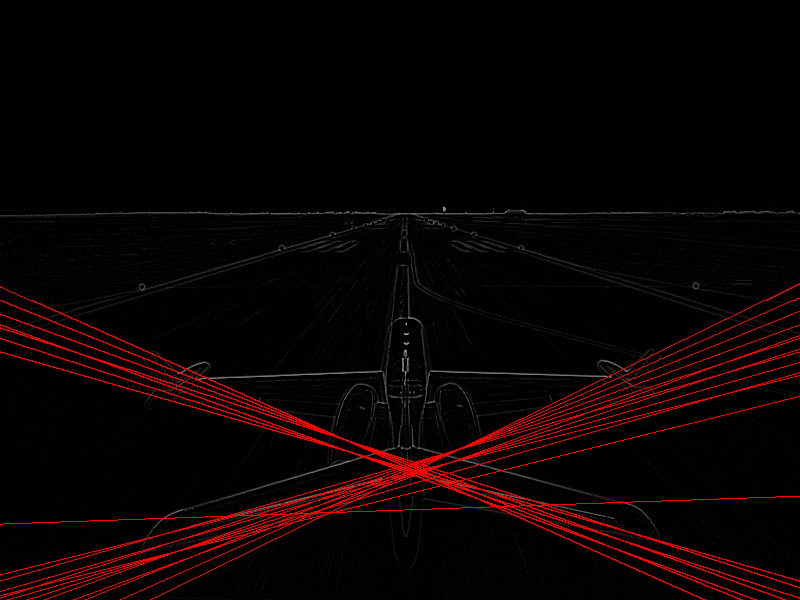

In [262]:
# codigo para ver la imagen de output

from PIL import Image
from IPython.display import display

# Nombre de tu archivo de imagen
nombre_archivo = 'output_with_lines.png'

try:
    # Cargar la imagen de forma correcta
    img = Image.open(nombre_archivo)

    print(f"Mostrando la imagen: {nombre_archivo}")
    display(img)

except FileNotFoundError:
    print(f"Error: El archivo '{nombre_archivo}' no se encontró. Asegúrate de que el nombre sea correcto y el archivo esté cargado en la sesión de Colab.")
except Exception as e:
    print(f"Ocurrió un error al intentar mostrar la imagen: {e}")